In [1]:
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

# NumPy NN

This notebook walks through the process of constructing a feed-forward neural network for multi-class classification solely using NumPy.

## Layers

For our neural network, we want to abstract away from individual neurons and focus on layers. Each element of the network will be defined by a certain layer.

### Base Layer

This layer provides the virtual methods that each layer has to implement. If the layer doesn't implement the method, we default to one of these empty methods.

In [2]:
class Layer:
    """Abstract base layer for our neural network."""

The `__init__` method sets up constant information about the layer that is necessary to build the graph later. Typically, only dimensions of input/output data is required.

In [3]:
    def __init__(self):
        """Initializes layer constants necessary to construct the graph
            for training. Likely: just dimension information or nothing
            at all."""

Layer.__init__ = __init__

The forward method computes the forward pass from the network. All layers should implement this method.

In [4]:
    def forward(self, X):
        """Executes the forward pass through the layer
            
        Args:
            X (ndarray): A matrix representing the inputs to the layer.
                Likely: A or Z depending on the layer.
        
        Returns:
            ndarray: A tensor representing the outputs of the layer. 
                Likely: Z or A depending on the layer.
                
        """

Layer.forward = forward

The backward method computes the backward pass step for a single layer. This should be implemented for all layers.

In [5]:
    def backward(self, dL):
        """Computes the backward pass for the layer.
            
        Args:
            dL (ndarray): A matrix representing the gradient of the loss
                of the network with respect to the outputs of the current
                layer. Likely: dLdA or dLdZ depending on the layer.
        
        Returns:
            ndarray: A matrix representing the gradient of the loss of the
                network will respect to the inputs of the current layer.
                Likely: dLdZ or dLdA depending on the layer.
        
        """

Layer.backward = backward

Any layer that has any variables needs to update these variables during stochastic gradient descent.

In [6]:
    def sgd_step(self, eta):
        """Updates trainable variables based off the results from the
            backward pass.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
                
        """

Layer.sgd_step = sgd_step

### Linear Layer

This is the simplest possible layer where all inputs are connected to all outputs.

In [7]:
class Linear(Layer):
    """Simple layer fully-connecting inputs to outputs linearly."""

To set up this layer, we need to know the input and output dimensions ahead of time. Using this information, we randomly initialize the weight matrices.

In [8]:
    def __init__(self, m, n):
        """Initializes the layer based on input and output dimensions. 

        Note: Kernel is initialized using normal distribution with mean 0 
        and variance 1 / m. All biases are initialized to zero.

        Args:
            m (int): Number of input features to the layer.
            n (int): Number of output features of the layer.

        """
        self.m = m
        self.n = n

        self.W0 = np.zeros((self.n, 1))
        self.W = np.random.normal(0, np.sqrt(1 / self.m), (self.m, self.n))

Linear.__init__ = __init__

With our variables defined, we can execute the forward pass. We take the activation $A$ from the previous layer and produce the current $Z$ pre-activation.

In [9]:
    def forward(self, A):
        """Computes the forward pass of the layer.
            
        Args:
            A (ndarray): An m by b matrix representing the activations from
                the previous layer with a batch of size b.
                
        Returns:
            ndarray: An n by b matrix, Z, representing the pre-activations
                as the output from this linear layer.
        
        """
        # We need this input later when computing the backward path.
        self.A = A

        return np.transpose(self.W) @ self.A + self.W0

Linear.forward = forward

For now, we will compute the gradients by hand using back-propogation. We take the gradient of the loss with respect to the pre-activations of the layer $\partial \mathrm{Loss} / \partial Z$ and compute the gradient of the loss with respect to the activations of the previous layer $\partial \mathrm{Loss} / \partial A$. 

In addition, we save gradients of the loss with respect to the weights ($\partial \mathrm{Loss} / \partial W$ and $\partial \mathrm{Loss} / \partial W_0$) for the stochastic gradient descent update step.

In [10]:
    def backward(self, dLdZ):
        """Computes the backward pass for the layer. Also records gradients
            of the loss with respect to weights for later stochastic 
            gradient descent updates.
        
        Args:
            dLdZ (ndarray): An n by b matrix representing the gradient of
                the loss with respect to the current layer's 
                pre-activations for a batch of size b.
                
        Returns:
            ndarray: An m by b matrix, dLdA, representing the gradient of 
                the loss with respect to the previous layer's activations.
        
        """
        # We store these gradients for use later in the sgd_step
        self.dLdW = self.A @ np.transpose(dLdZ)
        self.dLdW0 = np.sum(dLdZ, axis=1, keepdims=True)

        return self.W @ dLdZ

Linear.backward = backward

The linear layer has some trainable parameters to update. Using the specified learning rate $\eta$, we can re-assign our variable values using stochastic gradient descent.

In [11]:
    def sgd_step(self, eta):
        """Updates the layer's variables using stochastic gradient
            descent.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
        
        """
        self.W -= eta * self.dLdW
        self.W0 -= eta * self.dLdW0
        
Linear.sgd_step = sgd_step

### Rectified Linear Unit Activation Layer

This layer applies the relu activation function to each of the inputs element-wise.

In [12]:
class ReLU(Layer):
    """Applies relu activation function to all inputs."""

We have no variables to consider, we just need to construct the forward and backward passes. With the forward pass we compute the activation $A$ using the previous layer's pre-activation $A$.

In [13]:
    def forward(self, Z):
        """Compute the forward pass output for the layer. 
            
        Args:
            Z (ndarray): An m by b matrix representing the pre-activations
                from the previous layer for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix, A, representing the activations from
                the current layer for a batch of size b. (Note: n and m 
                are equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = np.maximum(0.0, Z)
        
        return self.A
    
ReLU.forward = forward

In the backward pass, we use the gradient of the loss with respect to the layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [14]:
    def backward(self, dLdA):
        """Computes the backward pass for the layer.
        
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of
                the loss with respect to the current layer's activations
                for a batch of size b.
        
        Returns:
            ndarray: An m by b matrix, dLdZ, representing the gradient of
                the loss with respect to the previous layer's activations
                for a batch of size b. (Note: n and m are equal.)
        
        """
        return np.sign(self.A) * dLdA
    
ReLU.backward = backward

### Hyperbolic Tangent Activation Layer

This layer applies the hyperbolic tangent activation function to each input element-wise.

In [15]:
class Tanh(Layer):
    """Applies hyperbolic tangent activation function to all inputs."""

There are no variables in this layer, thus we only need to worry about forward and backward passes. The forward pass takes the previous layer's pre-activation $Z$ and produces the activation $A$.

In [16]:
    def forward(self, Z):
        """Computes the forward pass activation for the layer.
        
        Args:
            Z (ndarray): An m by b matrix representing the previous layer's
                pre-activation for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix, A, representing the layer's 
                activation for a batch of size b. (Note: m and n are
                equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = np.tanh(Z)

        return self.A

Tanh.forward = forward

The backward pass uses the gradient of the loss with respect to the layer's activation $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activation $\partial \mathrm{Loss} / \partial Z$.

In [17]:
    def backward(self, dLdA):
        """Computes the backward pass for the layer.
        
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of
                the loss with respect to this layer's activation for a 
                batch of size b.
                
        Returns:
            ndarray: An m by b matrix, dLdZ, representing the gradient of 
                the loss with respect to the previous layer's 
                pre-activation for a batch of size b. (Note: n and m are 
                equal.)
                
        """
        return (1.0 - self.A ** 2.0) * dLdA

Tanh.backward = backward

### Softmax Activation Layer

This layer applies the softmax activation function to the inputs.

In [18]:
class SoftMax(Layer):
    """Applies the softmax activation function to layer inputs."""

As with the other activation layers, there are no variables to consider. The forward pass takes the previous layer's pre-activations $Z$ and computes the current layer's activation $A$.

In [19]:
    def forward(self, Z):
        """Computes the forward pass activations for the layer.
            
        Args:
            Z (ndarray): An m by b matrix representing the previous layer's
                pre-activation for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix, A, representing the current layer's
                activation for a batch of size b. (Note: m and n are
                equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = np.exp(Z) / np.sum(np.exp(Z), axis=0, keepdims=True)
        
        return self.A

SoftMax.forward = forward

In the backward pass, we use the gradient of the loss with respect to the current layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [20]:
    def backward(self, dLdA):
        """Computes the backward pass for the layer.
            
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of
                the loss with respect to the current layer's activation.
                
        Returns:
            ndarray: An m by b tensor, dLdZ, representing the gradient of 
                the loss with respect to the previous layer's 
                pre-activation. (Note: n and m are equal.)
            
        """
        n = dLdA.shape[0]
        
        # This is just a way to compute dLdZ by using the provided dLdA
        # and softmax's dAdZ tensor. Or you can assume dLdZ is passed in.
        return np.einsum('ikj,kj->ij', np.einsum('jk,jk,ji->ijk', self.A, 1.0 - self.A, np.eye(n)) + np.einsum('jk,ik,ji->ijk', -self.A, self.A, 1.0 - np.eye(n)), dLdA)

SoftMax.backward = backward

### Negative Log-Likelihood Multi-Class Loss Layer

This layer computes the loss of the output of the network compared with the expected results.

In [21]:
class NLLM(Layer):
    """Computes the negative log-likelihood multi-class loss for neural
        network outputs and expected outputs."""

Like the activation layers, there are no variables to consider. The forward pass takes the neural network's final activations $A$ and the expected outputs
$Y$ and computes the loss scalar.

In [22]:
    def forward(self, A, Y):
        """Computes the loss of predictions vs expected outputs.
            
        Args:
            A (ndarray): An n by b matrix representing the neural network's
                outputs for a batch of size b.
            Y (ndarray): An n by b matrix representing the expected outputs
                from the neural network for a batch of size b.
        
        Returns:
            float: A scalar, L, which represents the loss of the neural
                network for a batch of size b.
        
        """
        # We will need both of these later to compute the backward pass.
        self.A = A
        self.Y = Y

        return -np.sum(self.Y * np.log(self.A))

NLLM.forward = forward

The backward pass computes the gradient of the loss with respect to the neural network's final activations $\partial \mathrm{Loss} / \partial A$. Note, this is not immediately computing $\partial \mathrm{Loss} / \partial Z$ by assuming softmax activations.

In [23]:
    def backward(self):
        """Computes the backward step for the loss.
        
        Returns:
            Tensor: An n by b tensor, dLdA, representing the gradient of
                the loss with respect to the neural network's outputs.
                
        """
        return -self.Y / self.A

NLLM.backward = backward

## Model

Now we have all the components to construct our neural network, but we need a model to connect them together.

### Sequential Model

The sequential model simply connects all the layer linearly.

In [24]:
class Sequential:
    """A standard neural network model with linearly stacked layers."""

The first step to construct the model is to provide a list of layers.

In [25]:
    def __init__(self, layers, loss):
        """Initialize the layers and the loss for the network.
        
        Args:
            layers (list of Layer): A list of layers in sequential order
                to construct the model from.
            loss (Layer): A layer used to construct the objective for
                stochastic gradient descent.
        
        """
        self.layers = layers
        self.loss = loss

Sequential.__init__ = __init__

To make predictions with the network, we use the `forward` method. This passes the data through every layer and returns the result.

In [26]:
    def forward(self, X):
        """Predicts the output for a training input batch.
        
        Args:
            X (ndarray): A d by b matrix of points to predict with 
                dimension d and batch size b.
        
        Returns:
            ndarray: A c by b matrix representing the predicted outputs 
                with c features of the neural network for a batch size b.
        
        """
        for layer in self.layers:
            X = layer.forward(X)
            
        return X

Sequential.forward = forward

To train the network, we will use stochastic gradient descent. Before we define the stochastic gradient descent training loop, we have to back-propogate the error throughout the layers of the network. To do this, we use the `backward` method.

In [27]:
    def backward(self, dL):
        """Computes the gradients of the loss with respect to each weight
        in the neural network to prepare for stochastic gradient descent.
        
        Args:
            dL (ndarray): An n by b tensor representing the gradient of the
                loss with respect to the output of the neural network.
        
        """
        for layer in self.layers[::-1]:
            dL = layer.backward(dL)

Sequential.backward = backward

Once the error is propogated through all the layers, each layer can update their weight matrices. For a single step, this is achieved through the `sgd_step` method.

In [28]:
    def sgd_step(self, eta):
        """Runs a single update step on the weight matrices throughout the
        neural network using stochastic gradient descent.
        
        Args:
            eta (float): A learning rate for stochastic gradient descent.
        
        """
        for layer in self.layers:
            layer.sgd_step(eta)

Sequential.sgd_step = sgd_step

Now we loop over the data applying many stochastic gradient descent update steps.

In [29]:
    def sgd(self, X_train, Y_train, epochs, eta):
        """Trains the neural network by running stochastic gradient descent.
        
        Args:
            X_train (ndarray): A d by n NumPy array representing n input
                training points each with d features.
            Y_train (ndarray): A c by n NumPy array representing n output
                training points each with c features.
            epochs (int): Number of iterations to run stochastic gradient
                descent.
            eta (float): A learning rate for stochastic gradient descent.
        
        """
        _, n = X.shape
        
        for epoch in range(epochs):
            
            t = np.random.randint(n)
            
            Xt = X[:, t:t + 1]
            Yt = Y[:, t:t + 1]
            
            loss = self.loss.forward(self.forward(Xt), Yt)
            self.backward(self.loss.backward())            
            self.sgd_step(eta)
            
            if epoch % 250 == 1:
                
                acc = np.mean(np.argmax(self.forward(X_train), axis=0) == np.argmax(Y_train, axis=0))
                print('Iteration =', epoch, '\tAcc =', acc, '\tLoss =', loss, flush=True)

Sequential.sgd = sgd

## Training

Our model is complete! Let's train it on some data and see how will it can classify. We will use the standard 'hard' data set used previously.

In [30]:
X = np.array([[-0.23390341,  1.18151883, -2.46493986,  1.55322202,  1.27621763,
                2.39710997, -1.34403040, -0.46903436, -0.64673502, -1.44029872,
               -1.37537243,  1.05994811, -0.93311512,  1.02735575, -0.84138778,
               -2.22585412, -0.42591102,  1.03561105,  0.91125595, -2.26550369],
              [-0.92254932, -1.10309630, -2.41956036, -1.15509002, -1.04805327,
                0.08717325,  0.81847250, -0.75171045,  0.60664705,  0.80410947,
               -0.11600488,  1.03747218, -0.67210575,  0.99944446, -0.65559838,
               -0.40744784, -0.58367642,  1.05972780, -0.95991874, -1.41720255]])

Y = np.array([[0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
              [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.]])

Let's start by taking a look at our data.

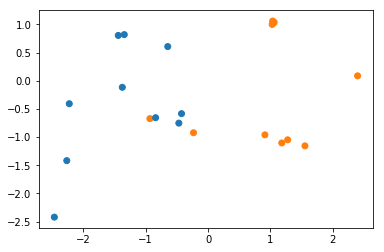

In [31]:
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))

Now we can construct a neural network we think might be able to classify these points.

In [32]:
model = Sequential([Linear(2, 10), ReLU(), 
                    Linear(10, 10), ReLU(), 
                    Linear(10, 2), SoftMax()], NLLM())

Let's try training the model on the data for a few thousand iterations.

In [33]:
model.sgd(X, Y, 100000, 0.005)

Iteration = 1 	Acc = 0.3 	Loss = 0.7688498024176027
Iteration = 251 	Acc = 0.7 	Loss = 0.7227086479860636
Iteration = 501 	Acc = 0.95 	Loss = 0.22725126343606974
Iteration = 751 	Acc = 0.95 	Loss = 0.49308214409011153
Iteration = 1001 	Acc = 0.95 	Loss = 0.5985567349213566
Iteration = 1251 	Acc = 0.9 	Loss = 0.0021923854937036706
Iteration = 1501 	Acc = 0.95 	Loss = 0.13244327706362838
Iteration = 1751 	Acc = 0.95 	Loss = 0.4779544679693506
Iteration = 2001 	Acc = 0.95 	Loss = 0.032823807140995614
Iteration = 2251 	Acc = 0.95 	Loss = 0.3889254506293234
Iteration = 2501 	Acc = 0.95 	Loss = 0.009707154883209093
Iteration = 2751 	Acc = 0.95 	Loss = 0.4017469114977696
Iteration = 3001 	Acc = 0.95 	Loss = 0.021375131893223345
Iteration = 3251 	Acc = 0.95 	Loss = 0.15429971662514563
Iteration = 3501 	Acc = 0.95 	Loss = 0.0004997254136731498
Iteration = 3751 	Acc = 0.95 	Loss = 0.005664656562346892
Iteration = 4001 	Acc = 0.95 	Loss = 0.0011771863322346087
Iteration = 4251 	Acc = 0.95 	Loss =

Iteration = 35001 	Acc = 1.0 	Loss = 0.00012573864556920494
Iteration = 35251 	Acc = 0.95 	Loss = 0.007489049294427614
Iteration = 35501 	Acc = 1.0 	Loss = 0.006452116039589023
Iteration = 35751 	Acc = 0.95 	Loss = 1.4696022176973995e-12
Iteration = 36001 	Acc = 0.95 	Loss = 0.004309764138967085
Iteration = 36251 	Acc = 0.95 	Loss = 0.07422340997921632
Iteration = 36501 	Acc = 0.95 	Loss = 3.675616603420684e-05
Iteration = 36751 	Acc = 0.95 	Loss = 0.003959660241477145
Iteration = 37001 	Acc = 0.95 	Loss = 3.369167001182116e-05
Iteration = 37251 	Acc = 1.0 	Loss = 2.218824203249962e-05
Iteration = 37501 	Acc = 1.0 	Loss = 6.92441033009123e-05
Iteration = 37751 	Acc = 0.95 	Loss = 2.2204460492503136e-16
Iteration = 38001 	Acc = 0.95 	Loss = 3.1240331974530763e-05
Iteration = 38251 	Acc = 0.95 	Loss = 0.0062699540182643955
Iteration = 38501 	Acc = 0.95 	Loss = 2.8478063897961193e-05
Iteration = 38751 	Acc = 0.95 	Loss = 1.7319479184152593e-14
Iteration = 39001 	Acc = 0.95 	Loss = 1.03250

Iteration = 71251 	Acc = 1.0 	Loss = 1.0012078412389748e-07
Iteration = 71501 	Acc = 1.0 	Loss = 3.7960557616140933e-06
Iteration = 71751 	Acc = 1.0 	Loss = 0.01141014349120305
Iteration = 72001 	Acc = 1.0 	Loss = -0.0
Iteration = 72251 	Acc = 1.0 	Loss = 0.000694511402376017
Iteration = 72501 	Acc = 1.0 	Loss = 5.5439426587472295e-08
Iteration = 72751 	Acc = 1.0 	Loss = 0.24908564165246921
Iteration = 73001 	Acc = 1.0 	Loss = 2.2093438190040858e-14
Iteration = 73251 	Acc = 1.0 	Loss = -0.0
Iteration = 73501 	Acc = 1.0 	Loss = 0.11211618933329084
Iteration = 73751 	Acc = 1.0 	Loss = 0.000832242226835554
Iteration = 74001 	Acc = 1.0 	Loss = 0.008666427610414577
Iteration = 74251 	Acc = 1.0 	Loss = 1.4172235301488469e-07
Iteration = 74501 	Acc = 1.0 	Loss = 0.24787757854994757
Iteration = 74751 	Acc = 1.0 	Loss = 7.965299459717195e-08
Iteration = 75001 	Acc = 1.0 	Loss = -0.0
Iteration = 75251 	Acc = 1.0 	Loss = 0.0003491558697197592
Iteration = 75501 	Acc = 1.0 	Loss = 0.006557440853924

Seems like it has fitted the data 100\%. Let's see what the decision boundary looks like.

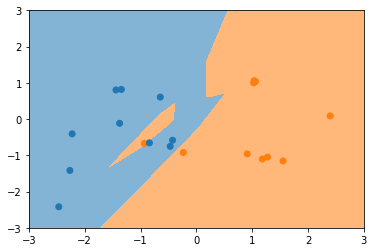

In [34]:
# Create a grid of points to classify
xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.005), np.arange(-3, 3, 0.005))

# Flatten the grid to pass into model
grid = np.c_[xx1.ravel(), xx2.ravel()].T

# Predict classification at every point on the grid
Z = model.forward(grid)[1,:].reshape(xx1.shape)

# Plot the prediction regions.
plt.imshow(Z, interpolation='bicubic', origin='lower', extent=[-3, 3, -3, 3], 
           cmap=ListedColormap(['#1f77b4', '#ff7f0e']), alpha=0.55, aspect='auto')

# Plot the original points.
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))